## Chiptune Generation Project Sandbox

Notebook for trying out some code in an interactive, sandbox-like environment.

In [24]:
from modules import mcc_waves, mcc_parser, mcc_builder

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

sr = 44100

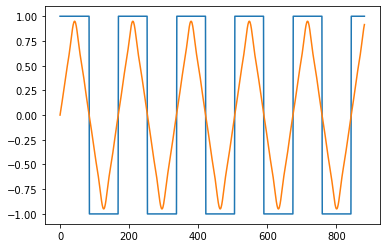

In [25]:
tri_wave = mcc_waves.triangle_wave(60, dur=.02)
sqr_wave = mcc_waves.square_wave(60, dur=.02)

plt.plot(sqr_wave)
plt.plot(tri_wave)

In [26]:
mid = mcc_parser.open_midi("data/castlevania.mid")

tracks = mcc_parser.extract_midi_tracks(mid.tracks)
track_waves = mcc_waves.create_all_track_waves(tracks, envl=True)
result = mcc_builder.combine_tracks(track_waves)